In [1]:
import os
import multiprocessing as mp
from communotron import *

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

#sns.set_theme(style="whitegrid", context='talk', font_scale=1., font="Helvetica")
sns.set_theme(style='ticks', context='talk', font_scale=2.5, font="Helvetica")

In [3]:
def simpsons_index(counts):
    """
    Given an array of nonnegative counts,
    compute 1 - sum((counts / sum(counts))^2).
    """
    counts = np.asarray(counts, dtype=float)
    total = counts.sum()
    if total == 0:
        return 0.0
    p = counts / total
    return 1 - np.sum(p**2)

In [4]:
%ls ./raw_data/april2025/

EnA0_EnB10_EnC200_size101_mStep10_pPred0.005_period300_Tsim1000__Tlim300_equal_dauer_exitFalse/
EnA10_EnB0_EnC200_size101_mStep10_pPred0.005_period300_Tsim1000__Tlim300_equal_dauer_exitFalse/
EnA10_EnB10_EnC0_size101_mStep10_pPred0.005_period300_Tsim1000__Tlim300_equal_dauer_exitFalse/
EnA10_EnB10_EnC200_size101_mStep10_pPred0.005_period300_Tsim1000__Tlim1000_equal_dauer_exitFalse/
EnA10_EnB10_EnC200_size101_mStep10_pPred0.005_period300_Tsim1000__Tlim300_equal_dauer_exitFalse/
EnA10_EnB10_EnC200_size101_mStep10_pPred0.005_period300_Tsim1000__Tlim300_equal_dauer_exitTrue/
EnA10_EnB10_EnC200_size101_mStep10_pPred0.005_period300_Tsim1000__Tlim600_equal_dauer_exitFalse/
EnA200_EnB200_EnC200_size101_mStep10_pPred0.005_period300_Tsim1000__Tlim300_equal_dauer_exitFalse/
EnA200_EnB200_EnC200_size101_mStep10_pPred0.005_period300_Tsim1000__Tlim600_equal_dauer_exitFalse/


### Figure 2D

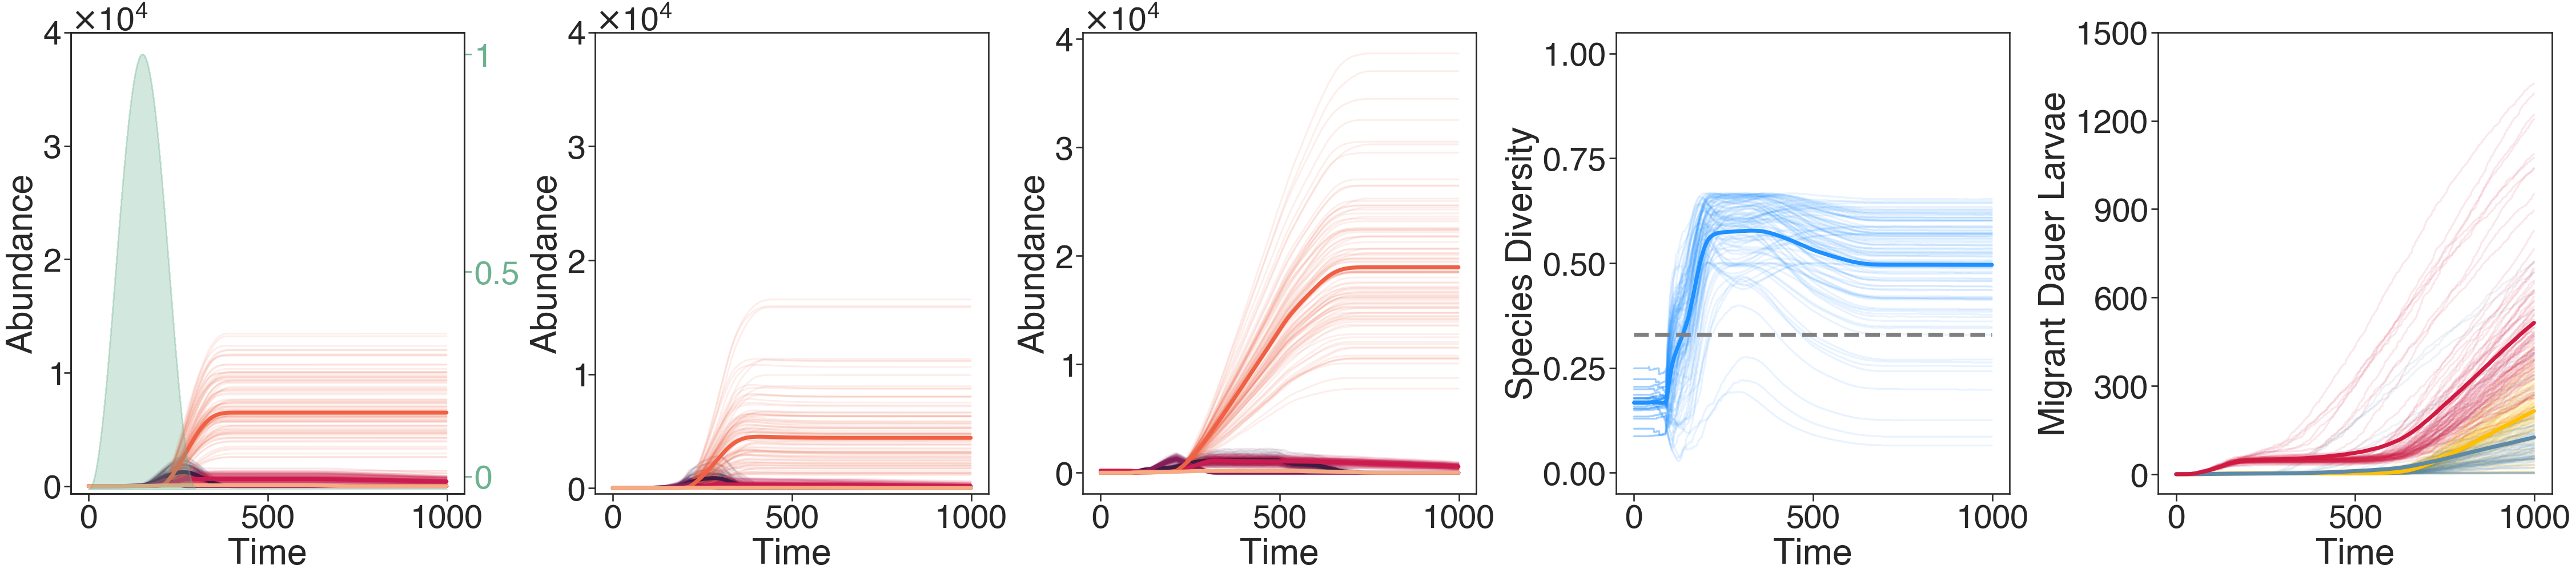

In [7]:
folder_path = './raw_data/april2025/EnA10_EnB10_EnC200_size101_mStep10_pPred0.005_period300_Tsim1000__Tlim300_equal_dauer_exitFalse/'
    
    # List to store DataFrames
dataframes = []


cols = [(0.29215894, 0.76144162, 0.67886578), (0.95922872, 0.53307513, 0.3748895), 'dodgerblue']
count = 0
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        # Read the CSV file and append the DataFrame to the list
        df = pd.read_csv(file_path)
        df['sim'] = count
        dataframes.append(df)
        count += 1
combined_df = pd.concat(dataframes, ignore_index=True)

combined_df["total"] = combined_df["E"] + combined_df["J"] + combined_df["A"] + combined_df["Dauer"] + combined_df["AJ"]

diversity_ind = pd.DataFrame()
for sim in combined_df["sim"].unique():
    sub1 = combined_df[combined_df["sim"]==sim]
    sub1 = sub1.iloc[3:]
    for time in sub1["Time"].unique():
        sub2 = sub1[sub1["Time"]==time]
        ind = np.round(simpsons_index(np.array(sub2['total'])), decimals=3)
        temp = pd.DataFrame({'sim': sim, 'Time': time, 'diversity_index': ind}, index=[0])
        diversity_ind = pd.concat([diversity_ind, temp], ignore_index=True)

fig, axes = plt.subplots(
    nrows=1,
    ncols=5,
    figsize=(45, 10),constrained_layout=True)

axes = axes.flatten()

# axes[0].errorbar(combined_df['Time'], combined_df['Resource'])

ax2 = axes[0].twinx()
#ax2.errorbar(combined_df['Time'], combined_df['Resource'])
ax2.fill_between(combined_df['Time'], combined_df['Resource'], 0, color=sns.color_palette("crest", n_colors=4)[0], alpha=0.3, zorder=0) 
ax2.tick_params(axis='y', which='both', color=sns.color_palette("crest", n_colors=4)[0], labelcolor=sns.color_palette("crest", n_colors=4)[0])
ax2.set_ylim(-0.01, 1.05)
ax2.set_yticks([0.03, 0.5, 1])
ax2.set_yticklabels([0, 0.5, 1])

for count, strain in enumerate(['A', 'B', 'C']):
    sub_df = combined_df[combined_df['Strain']==strain]
    sims = sub_df['sim'].unique()
    cols = sns.color_palette("rocket", n_colors=5)
    for col, dev in enumerate(['E', 'J', 'Dauer', 'AJ', 'A']):
        for i in sims:
            sub_df2 = sub_df[sub_df['sim']==i]
            axes[count].plot(sub_df2['Time'], sub_df2[dev], color=cols[col], alpha=0.1, zorder=1)
        if strain == 'A':
            axes[count].plot(sub_df.groupby('Time')[dev].mean(), color=cols[col], lw=5, zorder=4)
        else:
            axes[count].plot(sub_df.groupby('Time')[dev].mean(), color=cols[col], lw=5, zorder=4)
        
# axes[0].legend(frameon=False)
sims = sub_df['sim'].unique()
for i in sims:
    temp = diversity_ind[diversity_ind['sim']==i]
    axes[3].plot(temp['Time'], temp['diversity_index'], color='dodgerblue', alpha=0.1)
axes[3].plot(diversity_ind.groupby('Time')['diversity_index'].mean(), color='dodgerblue', lw=5, zorder=4)
axes[3].plot(temp['Time'], [0.33 for i in range(len(temp['Time']))], color='gray', ls='--', lw=5, zorder=4)
axes[3].set_yticks(np.linspace(0, 1, 5))
axes[3].set_ylim(-0.05, 1.05)

formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((0, 0))  # Force scientific notation at all magnitudes

axes[1].set_yticks([0, 5000, 10000, 15000])
axes[1].set_ylim(-500, 15000+500)

axes[0].set_yticks(np.linspace(0, 15000, 4))

for ax in axes[:3]:
    #ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    ax.yaxis.set_major_formatter(formatter)

 
cols = [(1.0, 0.75, 0.0), (0.36, 0.54, 0.66), (0.82, 0.1, 0.26)]
for count, strain in enumerate(['A', 'B', 'C']):
    sub_df = combined_df[combined_df['Strain']==strain]
    sims = sub_df['sim'].unique()
    for i in sims:
        sub_df2 = sub_df[sub_df['sim']==i]
        axes[-1].plot(sub_df2['Time'], sub_df2['cum_migrated'],  color=cols[count], alpha=0.1, zorder=1)
    axes[-1].plot(sub_df.groupby('Time')['cum_migrated'].mean(), color=cols[count], lw=5, zorder=4)

for ax in axes:
    ax.set_xlabel('Time')

for ax in axes[:3]:
    ax.set_ylabel('Abundance')

axes[3].set_ylabel('Species Diversity')
axes[-1].set_ylabel('Migrant Dauer Larvae')

axes[0].set_yticks(np.linspace(0, 40000, 5))
axes[1].set_yticks(np.linspace(0, 40000, 5))
axes[2].set_yticks(np.linspace(0, 40000, 5))

axes[-1].set_yticks(np.linspace(0, 1500, 6))

plt.savefig('./figures/fig2d.pdf', bbox_inches='tight', dpi=200);


### Figure 2E

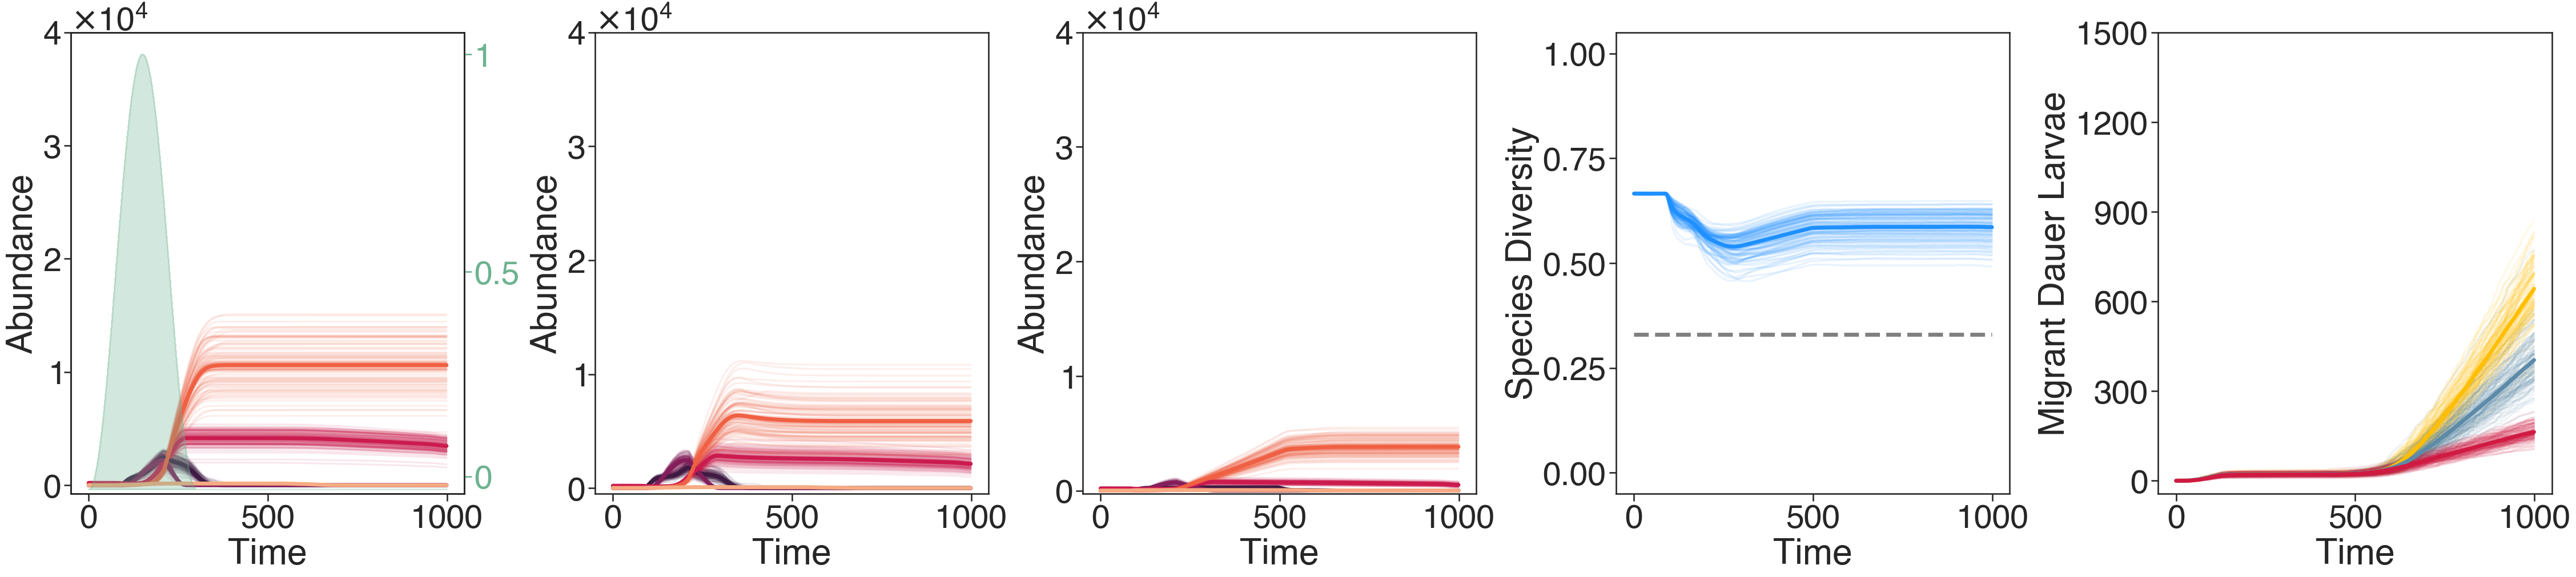

In [8]:
folder_path = './raw_data/april2025/EnA200_EnB200_EnC200_size101_mStep10_pPred0.005_period300_Tsim1000__Tlim300_equal_dauer_exitFalse/'
    
    # List to store DataFrames
dataframes = []


cols = [(0.29215894, 0.76144162, 0.67886578), (0.95922872, 0.53307513, 0.3748895), 'dodgerblue']
count = 0
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        # Read the CSV file and append the DataFrame to the list
        df = pd.read_csv(file_path)
        df['sim'] = count
        dataframes.append(df)
        count += 1
combined_df = pd.concat(dataframes, ignore_index=True)

combined_df["total"] = combined_df["E"] + combined_df["J"] + combined_df["A"] + combined_df["Dauer"] + combined_df["AJ"]

diversity_ind = pd.DataFrame()
for sim in combined_df["sim"].unique():
    sub1 = combined_df[combined_df["sim"]==sim]
    sub1 = sub1.iloc[3:]
    for time in sub1["Time"].unique():
        sub2 = sub1[sub1["Time"]==time]
        ind = np.round(simpsons_index(np.array(sub2['total'])), decimals=3)
        temp = pd.DataFrame({'sim': sim, 'Time': time, 'diversity_index': ind}, index=[0])
        diversity_ind = pd.concat([diversity_ind, temp], ignore_index=True)

fig, axes = plt.subplots(
    nrows=1,
    ncols=5,
    figsize=(45, 10),constrained_layout=True)

axes = axes.flatten()

# axes[0].errorbar(combined_df['Time'], combined_df['Resource'])

ax2 = axes[0].twinx()
#ax2.errorbar(combined_df['Time'], combined_df['Resource'])
ax2.fill_between(combined_df['Time'], combined_df['Resource'], 0, color=sns.color_palette("crest", n_colors=4)[0], alpha=0.3, zorder=0) 
ax2.tick_params(axis='y', which='both', color=sns.color_palette("crest", n_colors=4)[0], labelcolor=sns.color_palette("crest", n_colors=4)[0])
ax2.set_ylim(-0.01, 1.05)
ax2.set_yticks([0.03, 0.5, 1])
ax2.set_yticklabels([0, 0.5, 1])

for count, strain in enumerate(['A', 'B', 'C']):
    sub_df = combined_df[combined_df['Strain']==strain]
    sims = sub_df['sim'].unique()
    cols = sns.color_palette("rocket", n_colors=5)
    for col, dev in enumerate(['E', 'J', 'Dauer', 'AJ', 'A']):
        for i in sims:
            sub_df2 = sub_df[sub_df['sim']==i]
            axes[count].plot(sub_df2['Time'], sub_df2[dev], color=cols[col], alpha=0.1, zorder=1)
        if strain == 'A':
            axes[count].plot(sub_df.groupby('Time')[dev].mean(), color=cols[col], lw=5, zorder=4)
        else:
            axes[count].plot(sub_df.groupby('Time')[dev].mean(), color=cols[col], lw=5, zorder=4)
        
# axes[0].legend(frameon=False)
sims = sub_df['sim'].unique()
for i in sims:
    temp = diversity_ind[diversity_ind['sim']==i]
    axes[3].plot(temp['Time'], temp['diversity_index'], color='dodgerblue', alpha=0.1)
axes[3].plot(diversity_ind.groupby('Time')['diversity_index'].mean(), color='dodgerblue', lw=5, zorder=4)
axes[3].plot(temp['Time'], [0.33 for i in range(len(temp['Time']))], color='gray', ls='--', lw=5, zorder=4)
axes[3].set_yticks(np.linspace(0, 1, 5))
axes[3].set_ylim(-0.05, 1.05)

formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((0, 0))  # Force scientific notation at all magnitudes

axes[1].set_yticks([0, 5000, 10000, 15000])
axes[1].set_ylim(-500, 15000+500)

axes[0].set_yticks(np.linspace(0, 15000, 4))

for ax in axes[:3]:
    #ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    ax.yaxis.set_major_formatter(formatter)

 
cols = [(1.0, 0.75, 0.0), (0.36, 0.54, 0.66), (0.82, 0.1, 0.26)]
for count, strain in enumerate(['A', 'B', 'C']):
    sub_df = combined_df[combined_df['Strain']==strain]
    sims = sub_df['sim'].unique()
    for i in sims:
        sub_df2 = sub_df[sub_df['sim']==i]
        axes[-1].plot(sub_df2['Time'], sub_df2['cum_migrated'],  color=cols[count], alpha=0.1, zorder=1)
    axes[-1].plot(sub_df.groupby('Time')['cum_migrated'].mean(), color=cols[count], lw=5, zorder=4)

for ax in axes:
    ax.set_xlabel('Time')

for ax in axes[:3]:
    ax.set_ylabel('Abundance')

axes[3].set_ylabel('Species Diversity')
axes[-1].set_ylabel('Migrant Dauer Larvae')

axes[0].set_yticks(np.linspace(0, 40000, 5))
axes[1].set_yticks(np.linspace(0, 40000, 5))
axes[2].set_yticks(np.linspace(0, 40000, 5))

axes[-1].set_yticks(np.linspace(0, 1500, 6))

plt.savefig('./figures/fig2e.pdf', bbox_inches='tight', dpi=200);


### Figure 3a

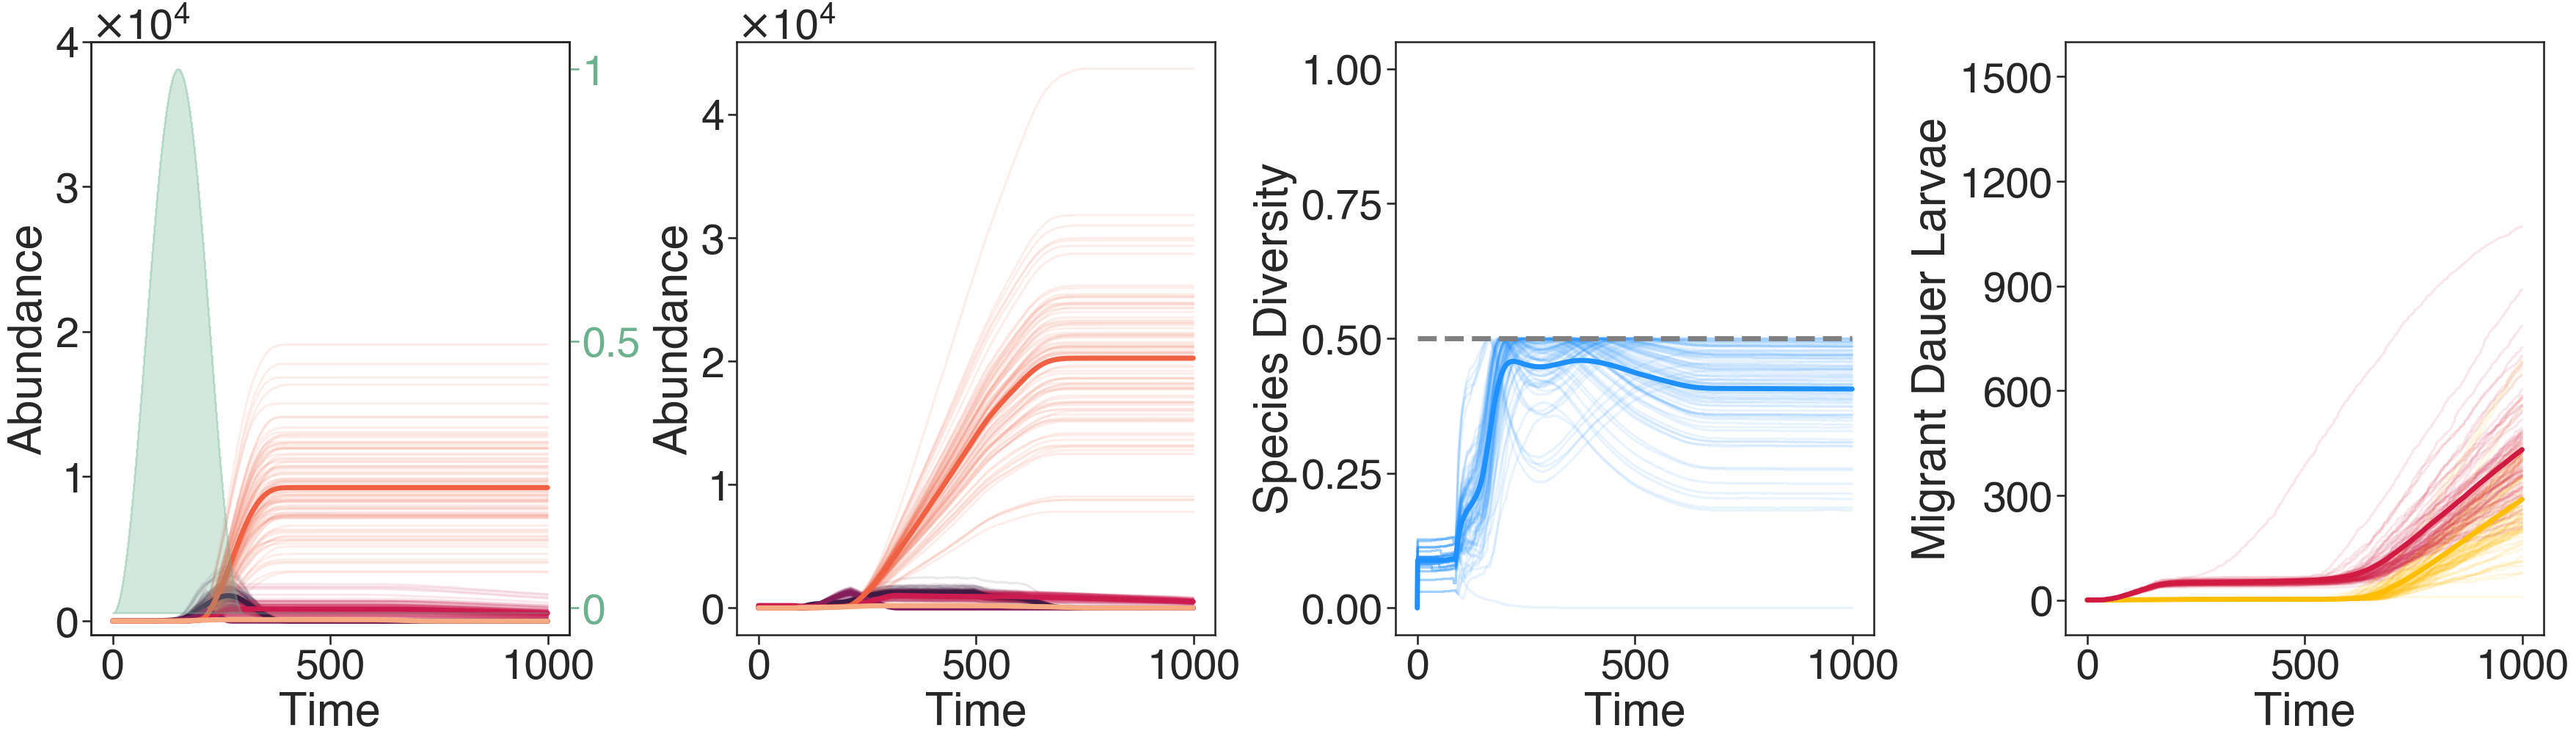

In [ ]:
folder_path = './raw_data/april2025/EnA10_EnB0_EnC200_size101_mStep10_pPred0.005_period300_Tsim1000__Tlim300_equal_dauer_exitFalse/'

dataframes = []


cols = [(0.29215894, 0.76144162, 0.67886578), (0.95922872, 0.53307513, 0.3748895), 'dodgerblue']
count = 0
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_csv(file_path)
        df['sim'] = count
        dataframes.append(df)
        count += 1
combined_df = pd.concat(dataframes, ignore_index=True)

combined_df = combined_df[combined_df['Strain'] != 'B']

combined_df["total"] = combined_df["E"] + combined_df["J"] + combined_df["A"] + combined_df["Dauer"] + combined_df["AJ"]

diversity_ind = pd.DataFrame()
for sim in combined_df["sim"].unique():
    sub1 = combined_df[combined_df["sim"]==sim]
    sub1 = sub1.iloc[3:]
    for time in sub1["Time"].unique():
        sub2 = sub1[sub1["Time"]==time]
        ind = np.round(simpsons_index(np.array(sub2['total'])), decimals=3)
        temp = pd.DataFrame({'sim': sim, 'Time': time, 'diversity_index': ind}, index=[0])
        diversity_ind = pd.concat([diversity_ind, temp], ignore_index=True)


fig, axes = plt.subplots(
    nrows=1,
    ncols=4,
    figsize=(35, 10),constrained_layout=True)

axes = axes.flatten()


ax2 = axes[0].twinx()
ax2.fill_between(combined_df['Time'], combined_df['Resource'], 0, color=sns.color_palette("crest", n_colors=4)[0], alpha=0.3, zorder=0) 
ax2.tick_params(axis='y', which='both', color=sns.color_palette("crest", n_colors=4)[0], labelcolor=sns.color_palette("crest", n_colors=4)[0])
ax2.set_ylim(-0.04, 1.05)
ax2.set_yticks([0.01, 0.5, 1])
ax2.set_yticklabels([0, 0.5, 1])


for count, strain in enumerate(['A', 'C']):
    sub_df = combined_df[combined_df['Strain']==strain]
    sims = sub_df['sim'].unique()
    cols = sns.color_palette("rocket", n_colors=5)
    for col, dev in enumerate(['E', 'J', 'Dauer', 'AJ', 'A']):
        for i in sims:
            sub_df2 = sub_df[sub_df['sim']==i]
            axes[count].plot(sub_df2['Time'], sub_df2[dev], color=cols[col], alpha=0.1, zorder=1)
        if strain == 'A':
            axes[count].plot(sub_df.groupby('Time')[dev].mean(), color=cols[col], lw=5, zorder=4)
        else:
            axes[count].plot(sub_df.groupby('Time')[dev].mean(), color=cols[col], lw=5, zorder=4)

sims = sub_df['sim'].unique()
for i in sims:
    temp = diversity_ind[diversity_ind['sim']==i]
    axes[2].plot(temp['Time'], temp['diversity_index'], color='dodgerblue', alpha=0.1)
axes[2].plot(diversity_ind.groupby('Time')['diversity_index'].mean(), color='dodgerblue', lw=5, zorder=4)
axes[2].plot(temp['Time'], [0.5 for i in range(len(temp['Time']))], color='gray', ls='--', lw=5, zorder=4)
axes[2].set_yticks(np.linspace(0, 1, 5))
axes[2].set_ylim(-0.05, 1.05)

formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((0, 0))  

for ax in axes[:2]:
    ax.yaxis.set_major_formatter(formatter)

 
cols = [(1.0, 0.75, 0.0), (0.36, 0.54, 0.66), (0.82, 0.1, 0.26)]
for count, strain in enumerate(['A','B', 'C']):
    if strain != "B":
        sub_df = combined_df[combined_df['Strain']==strain]
        sims = sub_df['sim'].unique()
        for i in sims:
            sub_df2 = sub_df[sub_df['sim']==i]
            axes[-1].plot(sub_df2['Time'], sub_df2['cum_migrated'],  color=cols[count], alpha=0.1, zorder=1)
        axes[-1].plot(sub_df.groupby('Time')['cum_migrated'].mean(), color=cols[count], lw=5, zorder=4)

for ax in axes:
    ax.set_xlabel('Time')

for ax in axes[:3]:
    ax.set_ylabel('Abundance')

axes[2].set_ylabel('Species Diversity')
axes[-1].set_ylabel('Migrant Dauer Larvae')
axes[0].set_yticks(np.linspace(0, 40000, 5))
axes[1].set_yticks(np.linspace(0, 40000, 5))
axes[-1].set_yticks(np.linspace(0, 1500, 6))
axes[-1].set_ylim(-100, 1500+100)


plt.savefig('./figures/fig3a.pdf', bbox_inches='tight', dpi=200);


### Figure 3b

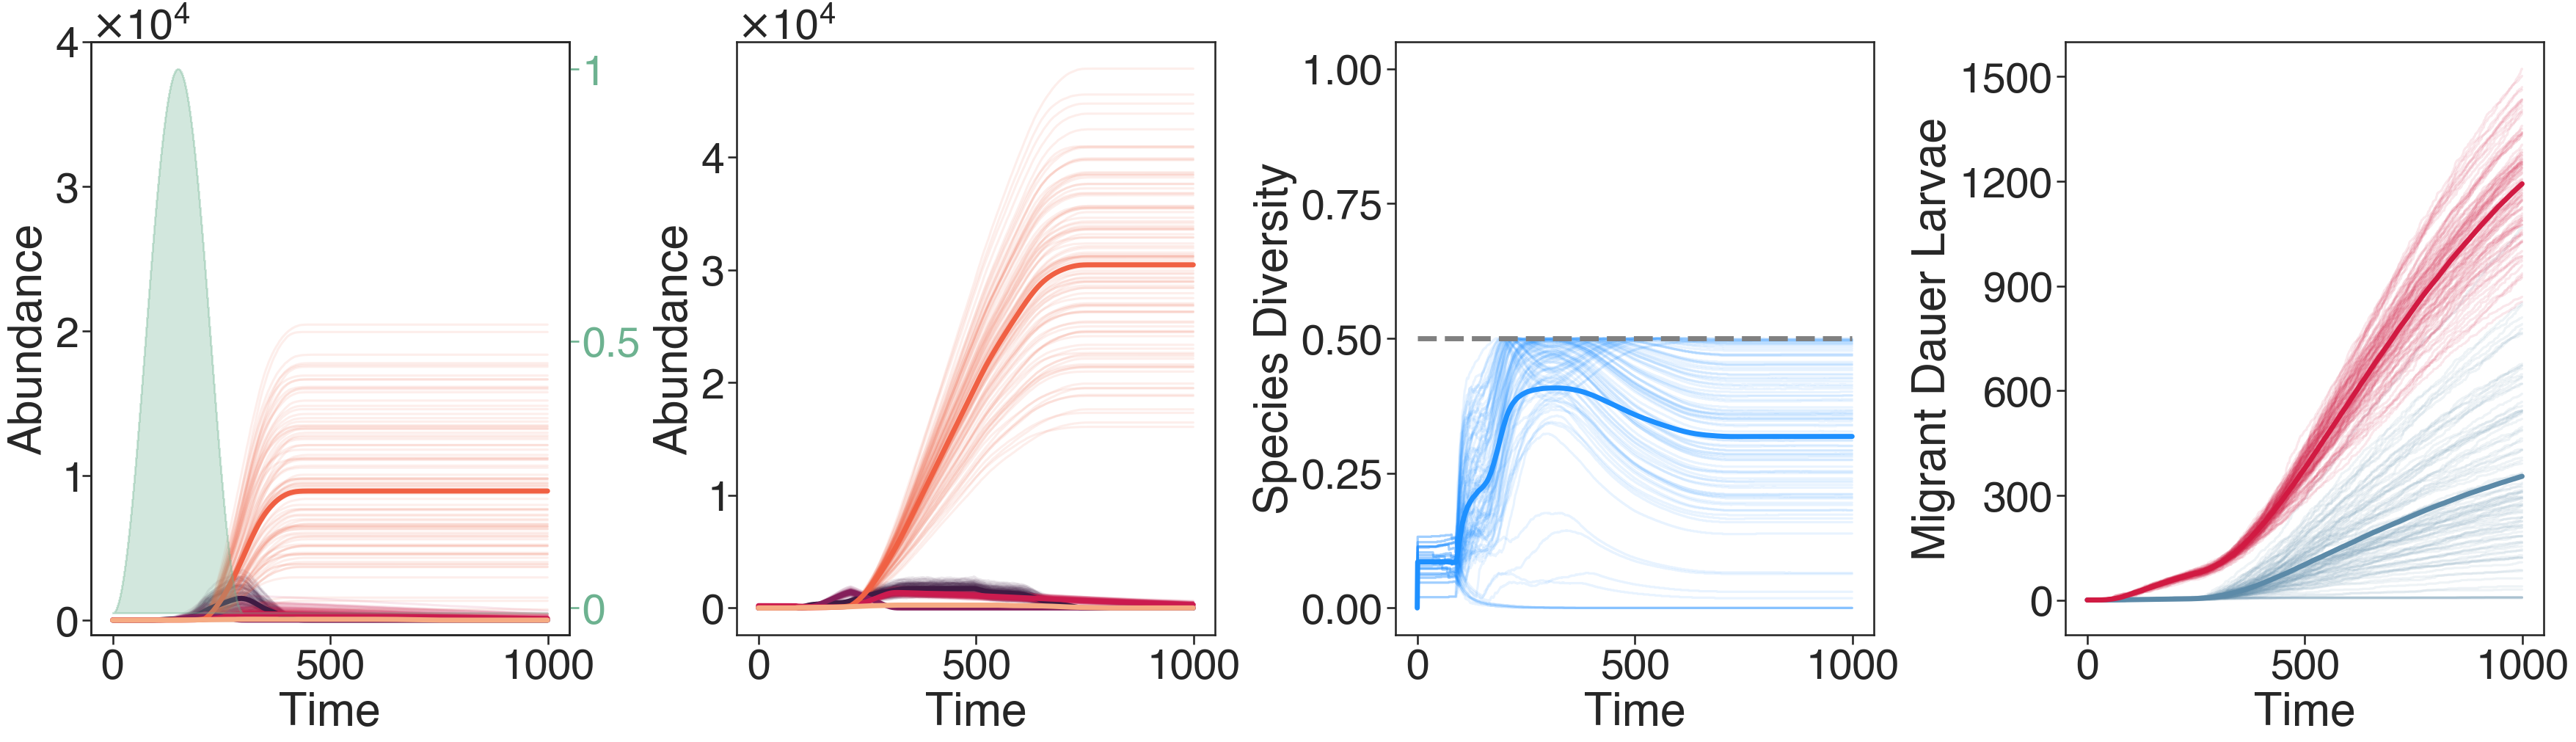

In [14]:
folder_path = './raw_data/april2025/EnA0_EnB10_EnC200_size101_mStep10_pPred0.005_period300_Tsim1000__Tlim300_equal_dauer_exitFalse/'
    

dataframes = []


cols = [(0.29215894, 0.76144162, 0.67886578), (0.95922872, 0.53307513, 0.3748895), 'dodgerblue']
count = 0
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_csv(file_path)
        df['sim'] = count
        dataframes.append(df)
        count += 1
combined_df = pd.concat(dataframes, ignore_index=True)

combined_df = combined_df[combined_df['Strain'] != 'A']

combined_df["total"] = combined_df["E"] + combined_df["J"] + combined_df["A"] + combined_df["Dauer"] + combined_df["AJ"]

diversity_ind = pd.DataFrame()
for sim in combined_df["sim"].unique():
    sub1 = combined_df[combined_df["sim"]==sim]
    sub1 = sub1.iloc[3:]
    for time in sub1["Time"].unique():
        sub2 = sub1[sub1["Time"]==time]
        ind = np.round(simpsons_index(np.array(sub2['total'])), decimals=3)
        temp = pd.DataFrame({'sim': sim, 'Time': time, 'diversity_index': ind}, index=[0])
        diversity_ind = pd.concat([diversity_ind, temp], ignore_index=True)

name = 'fig3b'

fig, axes = plt.subplots(
    nrows=1,
    ncols=4,
    figsize=(35, 10),constrained_layout=True)

axes = axes.flatten()


ax2 = axes[0].twinx()
ax2.fill_between(combined_df['Time'], combined_df['Resource'], 0, color=sns.color_palette("crest", n_colors=4)[0], alpha=0.3, zorder=0) 
ax2.tick_params(axis='y', which='both', color=sns.color_palette("crest", n_colors=4)[0], labelcolor=sns.color_palette("crest", n_colors=4)[0])
ax2.set_ylim(-0.04, 1.05)
ax2.set_yticks([0.01, 0.5, 1])
ax2.set_yticklabels([0, 0.5, 1])


for count, strain in enumerate(['B', 'C']):
    sub_df = combined_df[combined_df['Strain']==strain]
    sims = sub_df['sim'].unique()
    cols = sns.color_palette("rocket", n_colors=5)
    for col, dev in enumerate(['E', 'J', 'Dauer', 'AJ', 'A']):
        for i in sims:
            sub_df2 = sub_df[sub_df['sim']==i]
            axes[count].plot(sub_df2['Time'], sub_df2[dev], color=cols[col], alpha=0.1, zorder=1)
        if strain == 'A':
            axes[count].plot(sub_df.groupby('Time')[dev].mean(), color=cols[col], lw=5, zorder=4)
        else:
            axes[count].plot(sub_df.groupby('Time')[dev].mean(), color=cols[col], lw=5, zorder=4)

sims = sub_df['sim'].unique()
for i in sims:
    temp = diversity_ind[diversity_ind['sim']==i]
    axes[2].plot(temp['Time'], temp['diversity_index'], color='dodgerblue', alpha=0.1)
axes[2].plot(diversity_ind.groupby('Time')['diversity_index'].mean(), color='dodgerblue', lw=5, zorder=4)
axes[2].plot(temp['Time'], [0.5 for i in range(len(temp['Time']))], color='gray', ls='--', lw=5, zorder=4)
axes[2].set_yticks(np.linspace(0, 1, 5))
axes[2].set_ylim(-0.05, 1.05)

formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((0, 0)) 


for ax in axes[:2]:
    ax.yaxis.set_major_formatter(formatter)

 
cols = [(1.0, 0.75, 0.0), (0.36, 0.54, 0.66), (0.82, 0.1, 0.26)]
for count, strain in enumerate(['A', 'B', 'C']):
    if strain != "A":
        sub_df = combined_df[combined_df['Strain']==strain]
        sims = sub_df['sim'].unique()
        for i in sims:
            sub_df2 = sub_df[sub_df['sim']==i]
            axes[-1].plot(sub_df2['Time'], sub_df2['cum_migrated'],  color=cols[count], alpha=0.1, zorder=1)
        axes[-1].plot(sub_df.groupby('Time')['cum_migrated'].mean(), color=cols[count], lw=5, zorder=4)

for ax in axes:
    ax.set_xlabel('Time')

for ax in axes[:3]:
    ax.set_ylabel('Abundance')

axes[2].set_ylabel('Species Diversity')
axes[-1].set_ylabel('Migrant Dauer Larvae')
axes[0].set_yticks(np.linspace(0, 40000, 5))
axes[1].set_yticks(np.linspace(0, 40000, 5))
axes[-1].set_yticks(np.linspace(0, 1500, 6))
axes[-1].set_ylim(-100, 1500+100)

plt.savefig('./figures/fig3b.pdf', bbox_inches='tight', dpi=200);


### Figure 3c

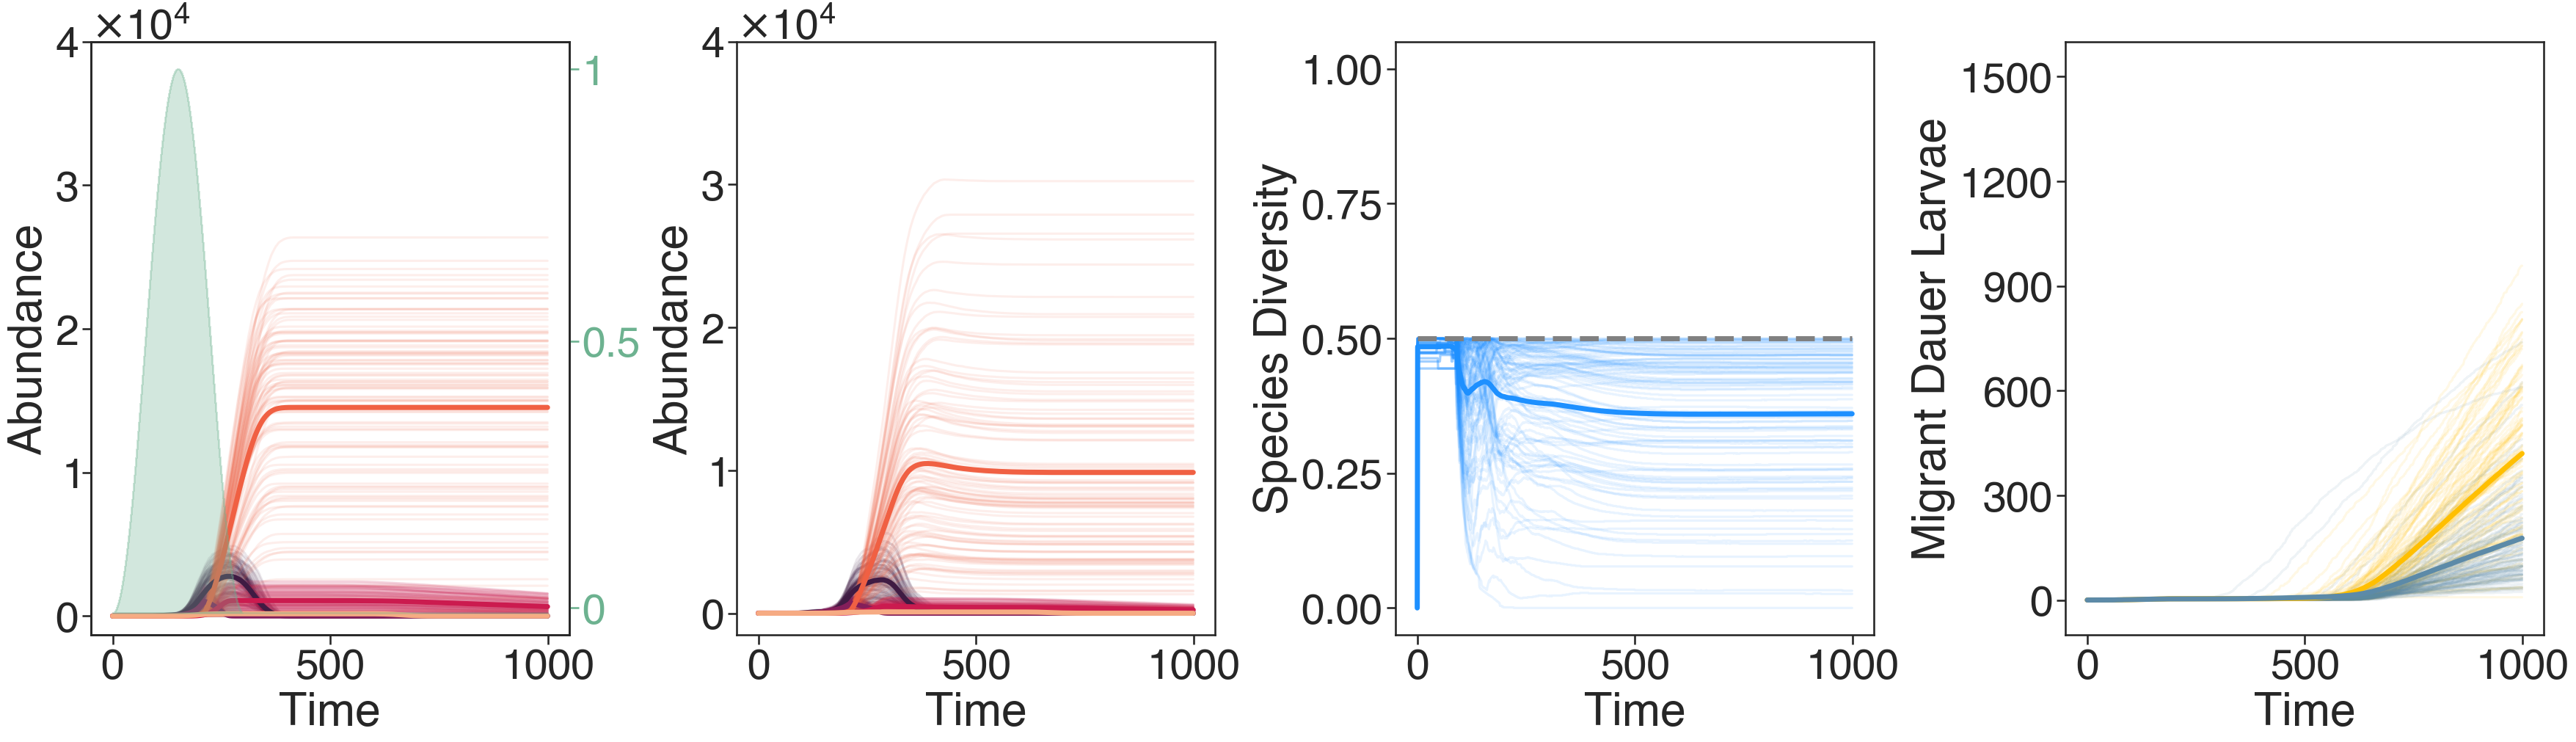

In [15]:
folder_path = './raw_data/april2025/EnA10_EnB10_EnC0_size101_mStep10_pPred0.005_period300_Tsim1000__Tlim300_equal_dauer_exitFalse/'
dataframes = []


cols = [(0.29215894, 0.76144162, 0.67886578), (0.95922872, 0.53307513, 0.3748895), 'dodgerblue']
count = 0
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        # Read the CSV file and append the DataFrame to the list
        df = pd.read_csv(file_path)
        df['sim'] = count
        dataframes.append(df)
        count += 1
combined_df = pd.concat(dataframes, ignore_index=True)

combined_df = combined_df[combined_df['Strain'] != 'C']

combined_df["total"] = combined_df["E"] + combined_df["J"] + combined_df["A"] + combined_df["Dauer"] + combined_df["AJ"]

diversity_ind = pd.DataFrame()
for sim in combined_df["sim"].unique():
    sub1 = combined_df[combined_df["sim"]==sim]
    sub1 = sub1.iloc[3:]
    for time in sub1["Time"].unique():
        sub2 = sub1[sub1["Time"]==time]
        ind = np.round(simpsons_index(np.array(sub2['total'])), decimals=3)
        temp = pd.DataFrame({'sim': sim, 'Time': time, 'diversity_index': ind}, index=[0])
        diversity_ind = pd.concat([diversity_ind, temp], ignore_index=True)

name = 'fig3a'

fig, axes = plt.subplots(
    nrows=1,
    ncols=4,
    figsize=(35, 10),constrained_layout=True)

axes = axes.flatten()


ax2 = axes[0].twinx()
ax2.fill_between(combined_df['Time'], combined_df['Resource'], 0, color=sns.color_palette("crest", n_colors=4)[0], alpha=0.3, zorder=0) 
ax2.tick_params(axis='y', which='both', color=sns.color_palette("crest", n_colors=4)[0], labelcolor=sns.color_palette("crest", n_colors=4)[0])
ax2.set_ylim(-0.04, 1.05)
ax2.set_yticks([0.01, 0.5, 1])
ax2.set_yticklabels([0, 0.5, 1])


for count, strain in enumerate(['A', 'B']):
    sub_df = combined_df[combined_df['Strain']==strain]
    sims = sub_df['sim'].unique()
    cols = sns.color_palette("rocket", n_colors=5)
    for col, dev in enumerate(['E', 'J', 'Dauer', 'AJ', 'A']):
        for i in sims:
            sub_df2 = sub_df[sub_df['sim']==i]
            axes[count].plot(sub_df2['Time'], sub_df2[dev], color=cols[col], alpha=0.1, zorder=1)
        if strain == 'A':
            axes[count].plot(sub_df.groupby('Time')[dev].mean(), color=cols[col], lw=5, zorder=4)
        else:
            axes[count].plot(sub_df.groupby('Time')[dev].mean(), color=cols[col], lw=5, zorder=4)

sims = sub_df['sim'].unique()
for i in sims:
    temp = diversity_ind[diversity_ind['sim']==i]
    axes[2].plot(temp['Time'], temp['diversity_index'], color='dodgerblue', alpha=0.1)
axes[2].plot(diversity_ind.groupby('Time')['diversity_index'].mean(), color='dodgerblue', lw=5, zorder=4)
axes[2].plot(temp['Time'], [0.5 for i in range(len(temp['Time']))], color='gray', ls='--', lw=5, zorder=4)
axes[2].set_yticks(np.linspace(0, 1, 5))
axes[2].set_ylim(-0.05, 1.05)

formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((0, 0))  

for ax in axes[:2]:
    ax.yaxis.set_major_formatter(formatter)

 
cols = [(1.0, 0.75, 0.0), (0.36, 0.54, 0.66), (0.82, 0.1, 0.26)]
for count, strain in enumerate(['A', 'B', 'C']):
    sub_df = combined_df[combined_df['Strain']==strain]
    sims = sub_df['sim'].unique()
    for i in sims:
        sub_df2 = sub_df[sub_df['sim']==i]
        axes[-1].plot(sub_df2['Time'], sub_df2['cum_migrated'],  color=cols[count], alpha=0.1, zorder=1)
    axes[-1].plot(sub_df.groupby('Time')['cum_migrated'].mean(), color=cols[count], lw=5, zorder=4)

for ax in axes:
    ax.set_xlabel('Time')

for ax in axes[:3]:
    ax.set_ylabel('Abundance')

axes[2].set_ylabel('Species Diversity')
axes[-1].set_ylabel('Migrant Dauer Larvae')
axes[0].set_yticks(np.linspace(0, 40000, 5))
axes[1].set_yticks(np.linspace(0, 40000, 5))
axes[-1].set_yticks(np.linspace(0, 1500, 6))
axes[-1].set_ylim(-100, 1500+100)

plt.savefig('./figures/fig3c.pdf', bbox_inches='tight', dpi=200);


### Figure 4a

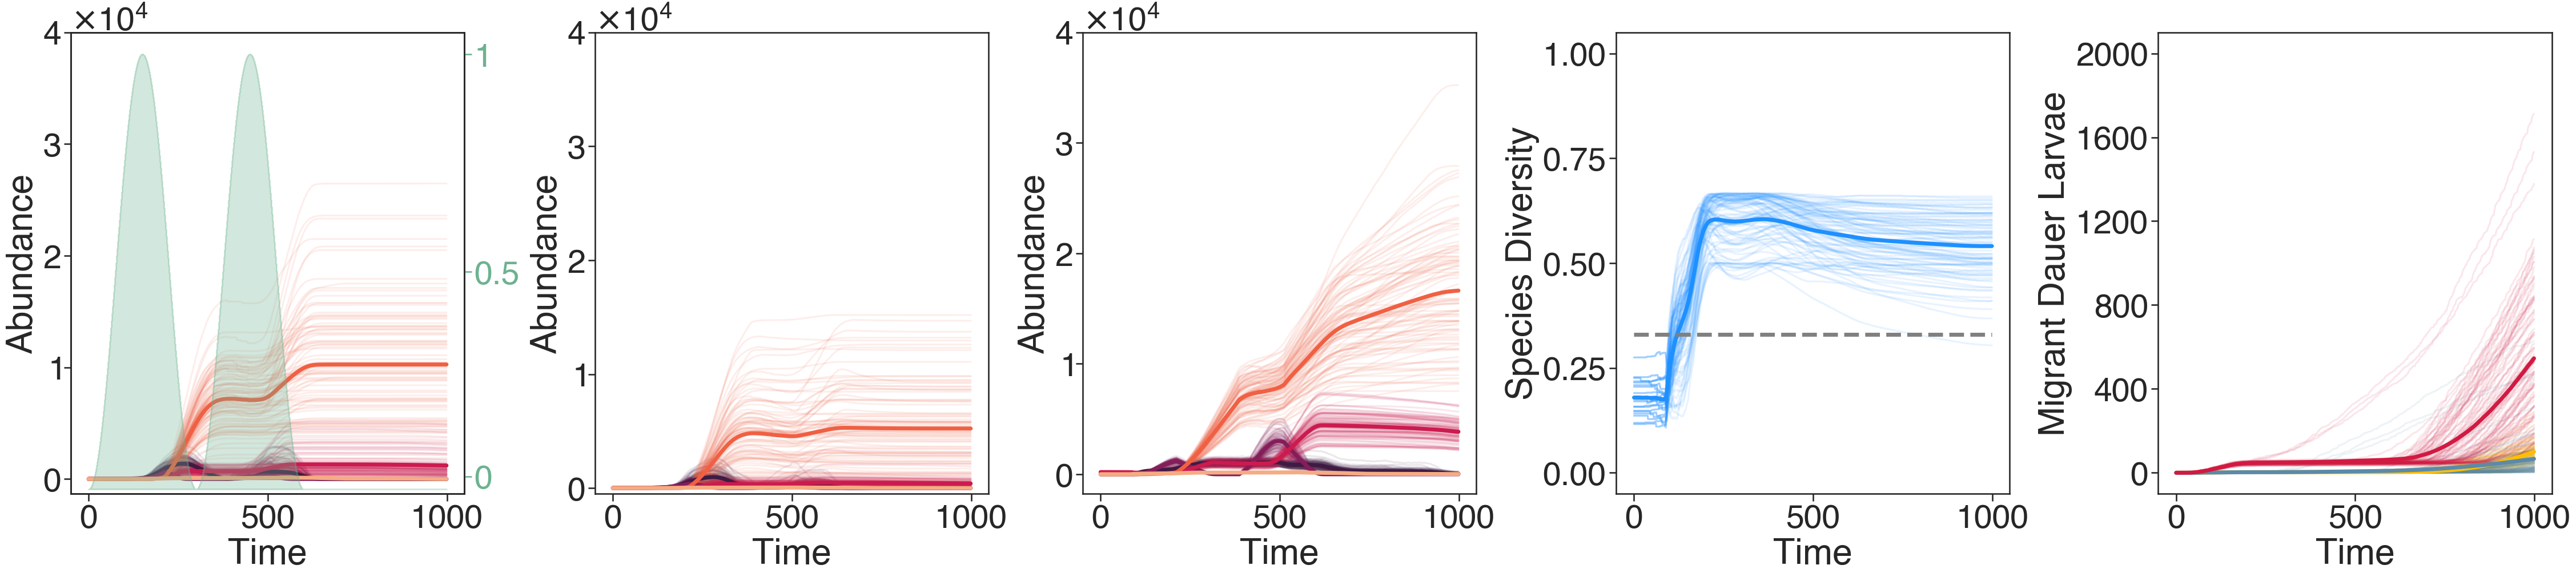

In [29]:
folder_path = './raw_data/april2025/EnA10_EnB10_EnC200_size101_mStep10_pPred0.005_period300_Tsim1000__Tlim600_equal_dauer_exitFalse/'
    

dataframes = []


cols = [(0.29215894, 0.76144162, 0.67886578), (0.95922872, 0.53307513, 0.3748895), 'dodgerblue']
count = 0
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_csv(file_path)
        df['sim'] = count
        dataframes.append(df)
        count += 1
combined_df = pd.concat(dataframes, ignore_index=True)

combined_df["total"] = combined_df["E"] + combined_df["J"] + combined_df["A"] + combined_df["Dauer"] + combined_df["AJ"]

diversity_ind = pd.DataFrame()
for sim in combined_df["sim"].unique():
    sub1 = combined_df[combined_df["sim"]==sim]
    sub1 = sub1.iloc[3:]
    for time in sub1["Time"].unique():
        sub2 = sub1[sub1["Time"]==time]
        ind = np.round(simpsons_index(np.array(sub2['total'])), decimals=3)
        temp = pd.DataFrame({'sim': sim, 'Time': time, 'diversity_index': ind}, index=[0])
        diversity_ind = pd.concat([diversity_ind, temp], ignore_index=True)

name = 'fig4a'

fig, axes = plt.subplots(
    nrows=1,
    ncols=5,
    figsize=(45, 10),constrained_layout=True)

axes = axes.flatten()

ax2 = axes[0].twinx()
ax2.fill_between(combined_df['Time'], combined_df['Resource'], 0, color=sns.color_palette("crest", n_colors=4)[0], alpha=0.3, zorder=0) 

ax2.tick_params(axis='y', which='both', color=sns.color_palette("crest", n_colors=4)[0], labelcolor=sns.color_palette("crest", n_colors=4)[0])
ax2.set_ylim(-0.01, 1.05)
ax2.set_yticks([0.03, 0.5, 1])
ax2.set_yticklabels([0, 0.5, 1])


for count, strain in enumerate(['A', 'B', 'C']):
    sub_df = combined_df[combined_df['Strain']==strain]
    sims = sub_df['sim'].unique()
    cols = sns.color_palette("rocket", n_colors=5)
    for col, dev in enumerate(['E', 'J', 'Dauer', 'AJ', 'A']):
        for i in sims:
            sub_df2 = sub_df[sub_df['sim']==i]
            axes[count].plot(sub_df2['Time'], sub_df2[dev], color=cols[col], alpha=0.1, zorder=1)
        if strain == 'A':
            axes[count].plot(sub_df.groupby('Time')[dev].mean(), color=cols[col], lw=5, zorder=4)
        else:
            axes[count].plot(sub_df.groupby('Time')[dev].mean(), color=cols[col], lw=5, zorder=4)

sims = sub_df['sim'].unique()
for i in sims:
    temp = diversity_ind[diversity_ind['sim']==i]
    axes[3].plot(temp['Time'], temp['diversity_index'], color='dodgerblue', alpha=0.1)
axes[3].plot(diversity_ind.groupby('Time')['diversity_index'].mean(), color='dodgerblue', lw=5, zorder=4)
axes[3].plot(temp['Time'], [0.33 for i in range(len(temp['Time']))], color='gray', ls='--', lw=5, zorder=4)
axes[3].set_yticks(np.linspace(0, 1, 5))
axes[3].set_ylim(-0.05, 1.05)

formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((0, 0)) 

axes[1].set_yticks([0, 5000, 10000, 15000])
axes[1].set_ylim(-500, 15000+500)

axes[0].set_yticks(np.linspace(0, 15000, 4))

for ax in axes[:3]:
    ax.yaxis.set_major_formatter(formatter)

 
cols = [(1.0, 0.75, 0.0), (0.36, 0.54, 0.66), (0.82, 0.1, 0.26)]
for count, strain in enumerate(['A', 'B', 'C']):
    sub_df = combined_df[combined_df['Strain']==strain]
    sims = sub_df['sim'].unique()
    for i in sims:
        sub_df2 = sub_df[sub_df['sim']==i]
        axes[-1].plot(sub_df2['Time'], sub_df2['cum_migrated'],  color=cols[count], alpha=0.1, zorder=1)
    axes[-1].plot(sub_df.groupby('Time')['cum_migrated'].mean(), color=cols[count], lw=5, zorder=4)

for ax in axes:
    ax.set_xlabel('Time')

for ax in axes[:3]:
    ax.set_ylabel('Abundance')

axes[3].set_ylabel('Species Diversity')
axes[-1].set_ylabel('Migrant Dauer Larvae')
axes[0].set_yticks(np.linspace(0, 40000, 5))
axes[1].set_yticks(np.linspace(0, 40000, 5))
axes[2].set_yticks(np.linspace(0, 40000, 5))
axes[-1].set_yticks(np.linspace(0, 2000, 6))
axes[-1].set_ylim(-100, 2100)


plt.savefig('./figures/fig4a.pdf', bbox_inches='tight', dpi=200);


### Figure 4b

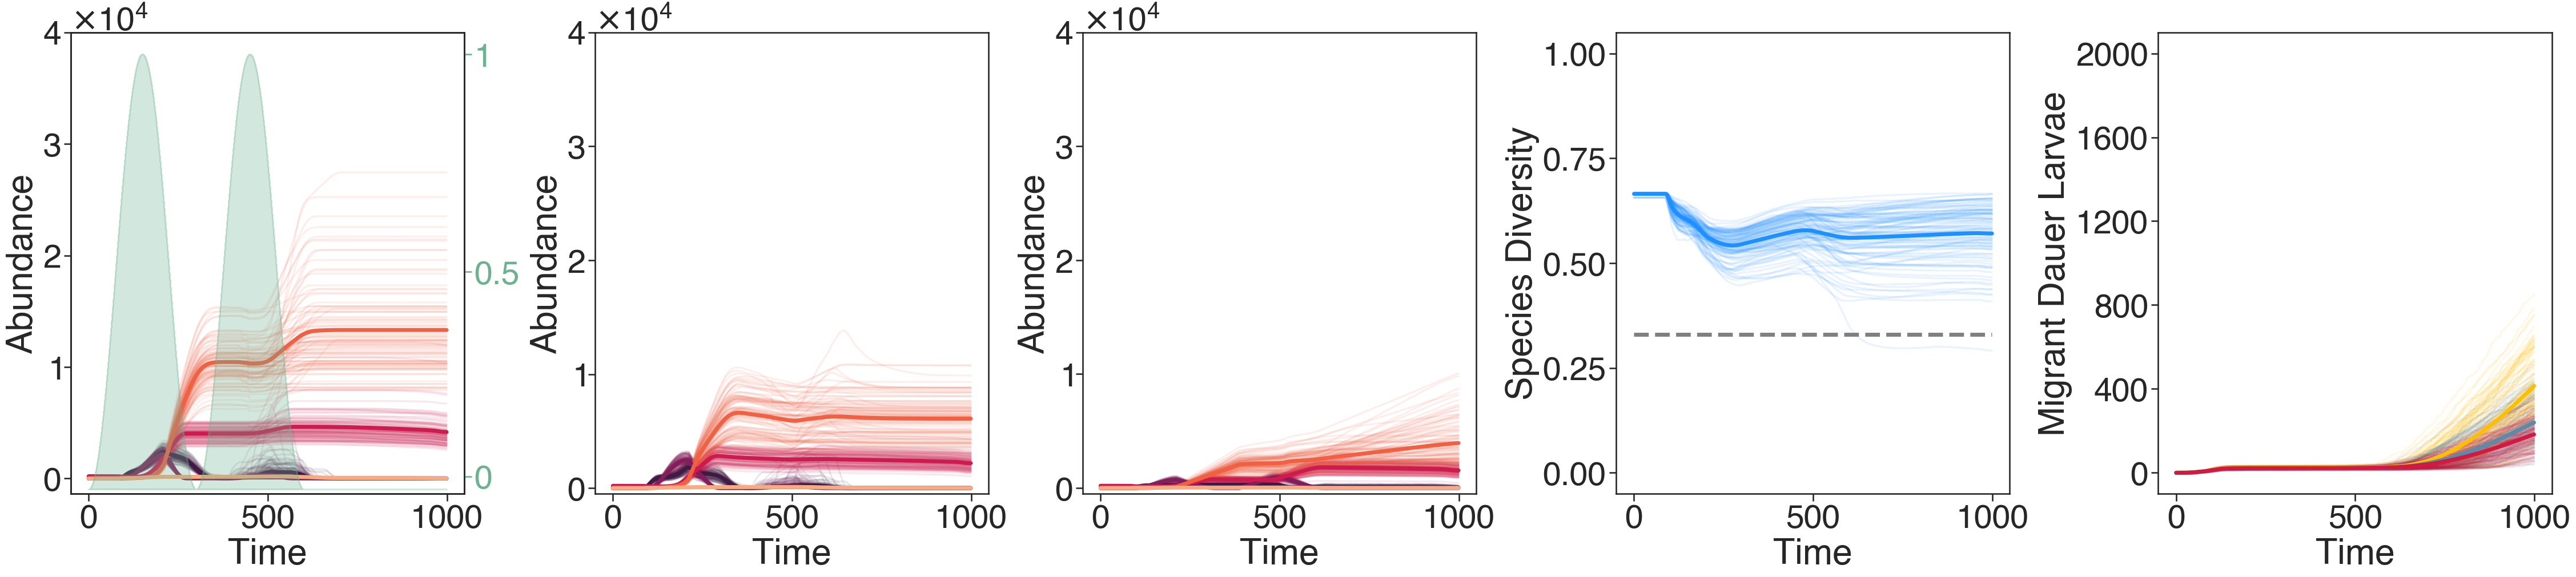

In [ ]:
folder_path = './raw_data/april2025/EnA200_EnB200_EnC200_size101_mStep10_pPred0.005_period300_Tsim1000__Tlim600_equal_dauer_exitFalse/'

dataframes = []


cols = [(0.29215894, 0.76144162, 0.67886578), (0.95922872, 0.53307513, 0.3748895), 'dodgerblue']
count = 0
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_csv(file_path)
        df['sim'] = count
        dataframes.append(df)
        count += 1
combined_df = pd.concat(dataframes, ignore_index=True)

combined_df["total"] = combined_df["E"] + combined_df["J"] + combined_df["A"] + combined_df["Dauer"] + combined_df["AJ"]

diversity_ind = pd.DataFrame()
for sim in combined_df["sim"].unique():
    sub1 = combined_df[combined_df["sim"]==sim]
    sub1 = sub1.iloc[3:]
    for time in sub1["Time"].unique():
        sub2 = sub1[sub1["Time"]==time]
        ind = np.round(simpsons_index(np.array(sub2['total'])), decimals=3)
        temp = pd.DataFrame({'sim': sim, 'Time': time, 'diversity_index': ind}, index=[0])
        diversity_ind = pd.concat([diversity_ind, temp], ignore_index=True)

fig, axes = plt.subplots(
    nrows=1,
    ncols=5,
    figsize=(45, 10),constrained_layout=True)

axes = axes.flatten()


ax2 = axes[0].twinx()
ax2.fill_between(combined_df['Time'], combined_df['Resource'], 0, color=sns.color_palette("crest", n_colors=4)[0], alpha=0.3, zorder=0) 

ax2.tick_params(axis='y', which='both', color=sns.color_palette("crest", n_colors=4)[0], labelcolor=sns.color_palette("crest", n_colors=4)[0])
ax2.set_ylim(-0.01, 1.05)
ax2.set_yticks([0.03, 0.5, 1])
ax2.set_yticklabels([0, 0.5, 1])


for count, strain in enumerate(['A', 'B', 'C']):
    sub_df = combined_df[combined_df['Strain']==strain]
    sims = sub_df['sim'].unique()
    cols = sns.color_palette("rocket", n_colors=5)
    for col, dev in enumerate(['E', 'J', 'Dauer', 'AJ', 'A']):
        for i in sims:
            sub_df2 = sub_df[sub_df['sim']==i]
            axes[count].plot(sub_df2['Time'], sub_df2[dev], color=cols[col], alpha=0.1, zorder=1)
        if strain == 'A':
            axes[count].plot(sub_df.groupby('Time')[dev].mean(), color=cols[col], lw=5, zorder=4)
        else:
            axes[count].plot(sub_df.groupby('Time')[dev].mean(), color=cols[col], lw=5, zorder=4)

sims = sub_df['sim'].unique()
for i in sims:
    temp = diversity_ind[diversity_ind['sim']==i]
    axes[3].plot(temp['Time'], temp['diversity_index'], color='dodgerblue', alpha=0.1)
axes[3].plot(diversity_ind.groupby('Time')['diversity_index'].mean(), color='dodgerblue', lw=5, zorder=4)
axes[3].plot(temp['Time'], [0.33 for i in range(len(temp['Time']))], color='gray', ls='--', lw=5, zorder=4)
axes[3].set_yticks(np.linspace(0, 1, 5))
axes[3].set_ylim(-0.05, 1.05)

formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((0, 0))  # Force scientific notation at all magnitudes

axes[1].set_yticks([0, 5000, 10000, 15000])
axes[1].set_ylim(-500, 15000+500)

axes[0].set_yticks(np.linspace(0, 15000, 4))

for ax in axes[:3]:
    ax.yaxis.set_major_formatter(formatter)

 
cols = [(1.0, 0.75, 0.0), (0.36, 0.54, 0.66), (0.82, 0.1, 0.26)]
for count, strain in enumerate(['A', 'B', 'C']):
    sub_df = combined_df[combined_df['Strain']==strain]
    sims = sub_df['sim'].unique()
    for i in sims:
        sub_df2 = sub_df[sub_df['sim']==i]
        axes[-1].plot(sub_df2['Time'], sub_df2['cum_migrated'],  color=cols[count], alpha=0.1, zorder=1)
    axes[-1].plot(sub_df.groupby('Time')['cum_migrated'].mean(), color=cols[count], lw=5, zorder=4)

for ax in axes:
    ax.set_xlabel('Time')

for ax in axes[:3]:
    ax.set_ylabel('Abundance')

axes[3].set_ylabel('Species Diversity')
axes[-1].set_ylabel('Migrant Dauer Larvae')

axes[0].set_yticks(np.linspace(0, 40000, 5))
axes[1].set_yticks(np.linspace(0, 40000, 5))
axes[2].set_yticks(np.linspace(0, 40000, 5))


axes[-1].set_yticks(np.linspace(0, 2000, 6))
axes[-1].set_ylim(-100, 2100)


plt.savefig('./figures/fig4b.pdf', bbox_inches='tight', dpi=200);

### Figure 4c

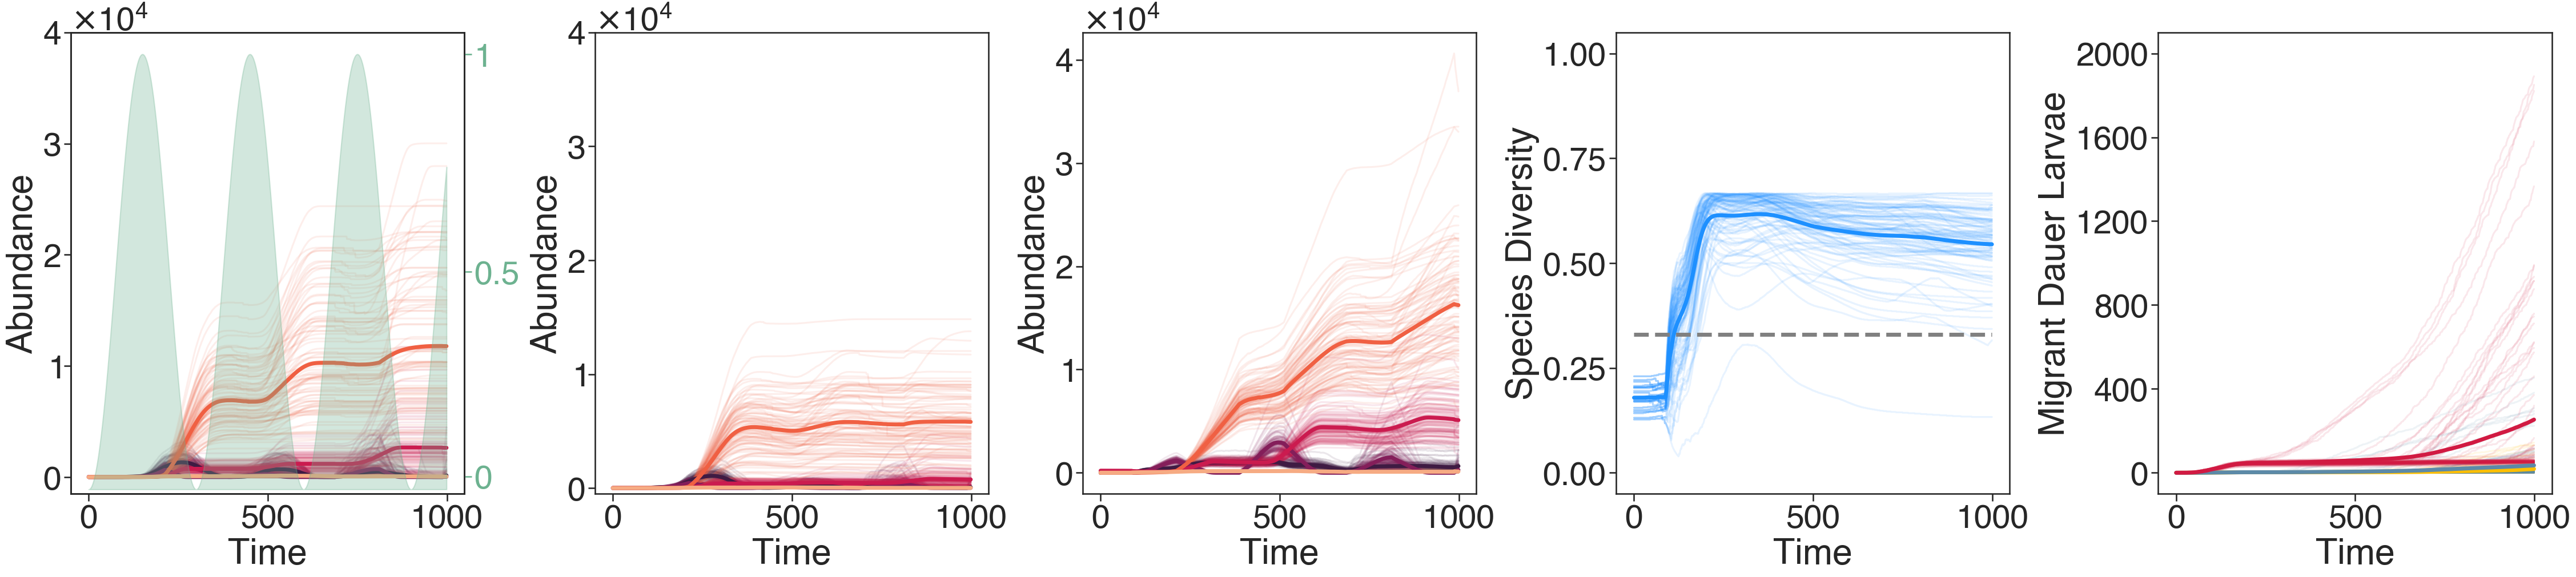

In [26]:
folder_path = './raw_data/april2025/EnA10_EnB10_EnC200_size101_mStep10_pPred0.005_period300_Tsim1000__Tlim1000_equal_dauer_exitFalse/'

dataframes = []


cols = [(0.29215894, 0.76144162, 0.67886578), (0.95922872, 0.53307513, 0.3748895), 'dodgerblue']
count = 0
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_csv(file_path)
        df['sim'] = count
        dataframes.append(df)
        count += 1
combined_df = pd.concat(dataframes, ignore_index=True)

combined_df["total"] = combined_df["E"] + combined_df["J"] + combined_df["A"] + combined_df["Dauer"] + combined_df["AJ"]

diversity_ind = pd.DataFrame()
for sim in combined_df["sim"].unique():
    sub1 = combined_df[combined_df["sim"]==sim]
    sub1 = sub1.iloc[3:]
    for time in sub1["Time"].unique():
        sub2 = sub1[sub1["Time"]==time]
        ind = np.round(simpsons_index(np.array(sub2['total'])), decimals=3)
        temp = pd.DataFrame({'sim': sim, 'Time': time, 'diversity_index': ind}, index=[0])
        diversity_ind = pd.concat([diversity_ind, temp], ignore_index=True)

name = 'fig4c'

fig, axes = plt.subplots(
    nrows=1,
    ncols=5,
    figsize=(45, 10),constrained_layout=True)

axes = axes.flatten()

ax2 = axes[0].twinx()
temp  = combined_df[(combined_df['sim'] == 0) & (combined_df['Strain'] == 'A')]
ax2.fill_between(temp['Time'], temp['Resource'], color=sns.color_palette("crest", n_colors=4)[0], alpha=0.3, zorder=0) 

ax2.tick_params(axis='y', which='both', color=sns.color_palette("crest", n_colors=4)[0], labelcolor=sns.color_palette("crest", n_colors=4)[0])
ax2.set_ylim(-0.01, 1.05)
ax2.set_yticks([0.03, 0.5, 1])
ax2.set_yticklabels([0, 0.5, 1])


for count, strain in enumerate(['A', 'B', 'C']):
    sub_df = combined_df[combined_df['Strain']==strain]
    sims = sub_df['sim'].unique()
    cols = sns.color_palette("rocket", n_colors=5)
    for col, dev in enumerate(['E', 'J', 'Dauer', 'AJ', 'A']):
        for i in sims:
            sub_df2 = sub_df[sub_df['sim']==i]
            axes[count].plot(sub_df2['Time'], sub_df2[dev], color=cols[col], alpha=0.1, zorder=1)
        if strain == 'A':
            axes[count].plot(sub_df.groupby('Time')[dev].mean(), color=cols[col], lw=5, zorder=4)
        else:
            axes[count].plot(sub_df.groupby('Time')[dev].mean(), color=cols[col], lw=5, zorder=4)

sims = sub_df['sim'].unique()
for i in sims:
    temp = diversity_ind[diversity_ind['sim']==i]
    axes[3].plot(temp['Time'], temp['diversity_index'], color='dodgerblue', alpha=0.1)
axes[3].plot(diversity_ind.groupby('Time')['diversity_index'].mean(), color='dodgerblue', lw=5, zorder=4)
axes[3].plot(temp['Time'], [0.33 for i in range(len(temp['Time']))], color='gray', ls='--', lw=5, zorder=4)
axes[3].set_yticks(np.linspace(0, 1, 5))
axes[3].set_ylim(-0.05, 1.05)

formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((0, 0))  

axes[1].set_yticks([0, 5000, 10000, 15000])
axes[1].set_ylim(-500, 15000+500)
axes[0].set_yticks(np.linspace(0, 15000, 4))

for ax in axes[:3]:
    ax.yaxis.set_major_formatter(formatter)

 
cols = [(1.0, 0.75, 0.0), (0.36, 0.54, 0.66), (0.82, 0.1, 0.26)]
for count, strain in enumerate(['A', 'B', 'C']):
    sub_df = combined_df[combined_df['Strain']==strain]
    sims = sub_df['sim'].unique()
    for i in sims:
        sub_df2 = sub_df[sub_df['sim']==i]
        axes[-1].plot(sub_df2['Time'], sub_df2['cum_migrated'],  color=cols[count], alpha=0.1, zorder=1)
    axes[-1].plot(sub_df.groupby('Time')['cum_migrated'].mean(), color=cols[count], lw=5, zorder=4)

for ax in axes:
    ax.set_xlabel('Time')

for ax in axes[:3]:
    ax.set_ylabel('Abundance')

axes[3].set_ylabel('Species Diversity')
axes[-1].set_ylabel('Migrant Dauer Larvae')
axes[0].set_yticks(np.linspace(0, 40000, 5))
axes[1].set_yticks(np.linspace(0, 40000, 5))
axes[2].set_yticks(np.linspace(0, 40000, 5))

axes[-1].set_yticks(np.linspace(0, 2000, 6))
axes[-1].set_ylim(-100, 2100)


plt.savefig('./figures/fig4c.pdf', bbox_inches='tight', dpi=200);


In [24]:
temp =[]
sub_df = combined_df[combined_df['Strain']=="C"]
sims = sub_df['sim'].unique()
for i in sims:
    sub_df2 = sub_df[sub_df['sim']==i]
    temp.append(np.sum(sub_df2['killed']))

{'whiskers': [<matplotlib.lines.Line2D at 0x337ff0920>,
 'caps': [<matplotlib.lines.Line2D at 0x337ff0470>,
 'boxes': [<matplotlib.lines.Line2D at 0x337ff10d0>],
 'medians': [<matplotlib.lines.Line2D at 0x337ff0dd0>],
 'fliers': [<matplotlib.lines.Line2D at 0x337ff1310>],
 'means': []}

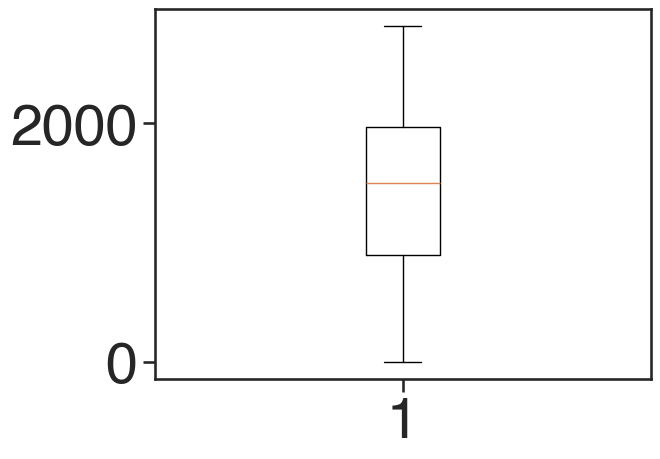

In [25]:
plt.boxplot(temp)